In [1]:
import os
import hashlib
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
from openai.types.chat import ChatCompletionMessageParam
from openai.types import CompletionUsage

GPT_MODEL = "ft:gpt-3.5-turbo-0125:personal::9bNq78hh"

In [2]:
from typing import Tuple, Dict, Any


client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

system_prompt = """
    You will be presented with a user intent, and your task is to extract the useful information and output it in JSON format as shown below:

    ```json
    {
    "action": "transfer",
    "chain": "Ethereum",
    "amount": "12",
    "token": "ETH",
    "receiver": "trump.eth"
    }
    ```

    If the intent is unknown, just say “I don't know”.
"""


def parse(intent: str) -> Tuple[str | None, CompletionUsage | None]:
    """
    Parse the user intent and return the extracted information in JSON format.
    """
    messages: list[ChatCompletionMessageParam] = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": intent},
    ]
    response = client.chat.completions.create(
        model=GPT_MODEL, messages=messages, temperature=0.7, max_tokens=500
    )
    result = response.choices[0].message.content
    return result, response.usage


def hash_output(message: str | None) -> str:
    """
    Hash the output message using MD5.
    """
    assert message is not None, "Message should not be None"
    md5_hash = hashlib.md5()
    md5_hash.update(message.encode())
    md5_hex = md5_hash.hexdigest()
    return md5_hex


# GPT-3.5 turbo model
# Training: $8.00 / 1M tokens
# Input: $3.00 / 1M tokens
# Output: $6.00 / 1M tokens
cost_per_input_token = 3.0 / 1e6
cost_per_output_token = 6.0 / 1e6


def calculate_pricing(usage: CompletionUsage | None) -> Tuple[int, float]:
    """
    Calculate the pricing for the current API usage.
    """
    assert usage is not None, "Usage should not be None"
    input_tokens = usage.prompt_tokens
    output_tokens = usage.completion_tokens
    # Calculate the price
    total_tokens = input_tokens + output_tokens
    price = cost_per_input_token * input_tokens + cost_per_output_token * output_tokens
    rounded_price = round(price, 6)
    return total_tokens, rounded_price

In [3]:
prompt = (
    "I want to approve spending of 10 USDC to trump.eth and send 10 USDT to biden.eth."
)


def run_simulation(num_iterations):
    results = []

    for _ in tqdm(range(num_iterations), desc="Running Simulation"):
        result, usage = parse(prompt)
        hash_value = hash_output(result)
        tokens, price = calculate_pricing(usage)
        results.append(
            {
                "hash": hash_value,
                "price": price,
                "tokens": tokens,
                "price": price,
                "result": result,
            }
        )

    df = pd.DataFrame(results)
    return df

In [4]:
df = run_simulation(2_000)
print(df.head())

Running Simulation: 100%|██████████| 2000/2000 [45:38<00:00,  1.37s/it]

                               hash     price  tokens  \
0  22b3709e21878139fa5d30248b08d737  0.000825     203   
1  22b3709e21878139fa5d30248b08d737  0.000825     203   
2  22b3709e21878139fa5d30248b08d737  0.000825     203   
3  22b3709e21878139fa5d30248b08d737  0.000825     203   
4  22b3709e21878139fa5d30248b08d737  0.000825     203   

                                              result  
0  [{"action": "approve", "chain": "Ethereum", "a...  
1  [{"action": "approve", "chain": "Ethereum", "a...  
2  [{"action": "approve", "chain": "Ethereum", "a...  
3  [{"action": "approve", "chain": "Ethereum", "a...  
4  [{"action": "approve", "chain": "Ethereum", "a...  


In [5]:
total_price = df["price"].sum()
print(f"Total Price: ${total_price:.2f}")

Total Price: $1.65


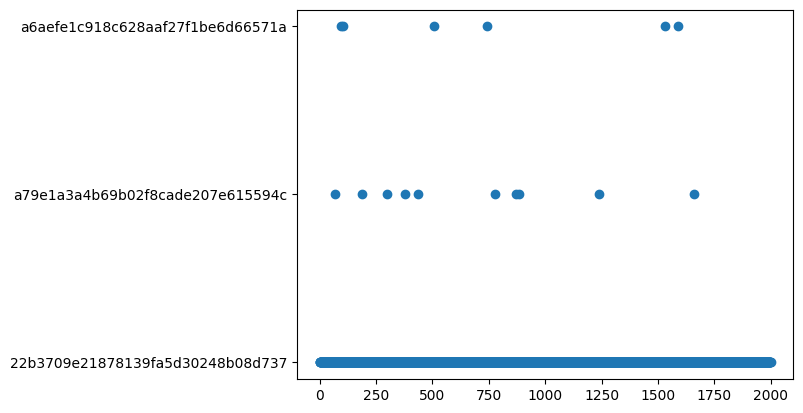

In [6]:
plt.scatter(df.index, df["hash"], label="Hash")
plt.show()

In [11]:
mode_value = df["hash"].mode()[0]
# Identify outliers
outliers = df[df["hash"] != mode_value]
# Count outliers
outlier_count = outliers.shape[0]

print(f"Number of outliers in 'hash': {outlier_count} among {df.shape[0]} samples")
print(f"outliers ratio: {outlier_count / df.shape[0]:.3f}")

Number of outliers in 'hash': 16 among 2000 samples
outliers ratio: 0.008


In [28]:
outlier1 = "a6aefe1c918c628aaf27f1be6d66571a"
outlier1_df = df[df["hash"] == outlier1]
print(f"Numbers of Outlier {outlier1}: {outlier1_df.shape[0]}")
print(f"Outlier {outlier1} result:\n{outlier1_df['result'].values[0]}")

outlier2 = "a79e1a3a4b69b02f8cade207e615594c"
outlier2_df = df[df["hash"] == outlier2]
print(f"Numbers of Outlier {outlier2}: {outlier2_df.shape[0]}")
print(f"Outlier {outlier2} result:\n{outlier2_df['result'].values[0]}")

Numbers of Outlier a6aefe1c918c628aaf27f1be6d66571a: 6
Outlier a6aefe1c918c628aaf27f1be6d66571a result:
[{"action": "transfer", "chain": "Ethereum", "amount": "10", "token": "USDC", "receiver": "trump.eth"}, {"action": "transfer", "chain": "Ethereum", "amount": "10", "token": "USDT", "receiver": "biden.eth"}]
Numbers of Outlier a79e1a3a4b69b02f8cade207e615594c: 10
Outlier a79e1a3a4b69b02f8cade207e615594c result:
[{"action": "transfer", "chain": "Ethereum", "amount": "10", "token": "USDT", "receiver": "biden.eth"}, {"action": "approve", "chain": "Ethereum", "amount": "10", "token": "USDC", "spender": "trump.eth"}]


In [26]:
df.to_csv("processed/simulation_result.csv")